In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from glob import glob
from ridgereliability.plots import posterior_reliability_diagram
from ridgereliability import metrics

EPOCHS = 40

In [2]:
model = tf.keras.applications.DenseNet121(
    include_top=True,
    weights=None,
    classes=10,
    input_shape=[32, 32, 3]
)

model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.CategoricalCrossentropy(),
    metrics=['accuracy'])

In [3]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()

mean = x_train.mean()
std = x_train.std()

x_train = (x_train - mean) / (std + 1e-7)
x_test = (x_test - mean) / (std + 1e-7)

y_train = tf.keras.utils.to_categorical(y_train)
y_test = tf.keras.utils.to_categorical(y_test)

In [4]:
datagen = tf.keras.preprocessing.image.ImageDataGenerator(
            featurewise_center=False,  # set input mean to 0 over the dataset
            samplewise_center=False,  # set each sample mean to 0
            featurewise_std_normalization=False,  # divide inputs by std of the dataset
            samplewise_std_normalization=False,  # divide each input by its std
            zca_whitening=False,  # apply ZCA whitening
            rotation_range=15,  # randomly rotate images in the range (degrees, 0 to 180)
            width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
            height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
            horizontal_flip=True,  # randomly flip images
            vertical_flip=False)  # randomly flip images
datagen.fit(x_train)

model.fit(datagen.flow(x_train, y_train, batch_size=128),
         epochs=EPOCHS,
         validation_data=(x_test, y_test))

  ...
    to  
  ['...']
Train for 391 steps, validate on 10000 samples
Epoch 1/40
391/391 [==============================] - 29s 75ms/step - loss: 1.5441 - accuracy: 0.4403 - val_loss: 1.3063 - val_accuracy: 0.5316
Epoch 2/40
391/391 [==============================] - 18s 47ms/step - loss: 1.1933 - accuracy: 0.5733 - val_loss: 1.2684 - val_accuracy: 0.5680
Epoch 3/40
391/391 [==============================] - 18s 47ms/step - loss: 1.0161 - accuracy: 0.6393 - val_loss: 1.2307 - val_accuracy: 0.5849
Epoch 4/40
391/391 [==============================] - 18s 47ms/step - loss: 0.9145 - accuracy: 0.6800 - val_loss: 1.0497 - val_accuracy: 0.6551
Epoch 5/40
391/391 [==============================] - 18s 47ms/step - loss: 0.8836 - accuracy: 0.6940 - val_loss: 4.5873 - val_accuracy: 0.5168
Epoch 6/40
391/391 [==============================] - 18s 47ms/step - loss: 0.8540 - accuracy: 0.7064 - val_loss: 2.8064 - val_accuracy: 0.5324
Epoch 7/40
391/391 [==============================] - 18s 47ms/s

In [5]:
model.save('models/cifar10_densenet.h5')

In [6]:
model = tf.keras.models.load_model('models/cifar10_densenet.h5')
z_test = model.predict(x_test, batch_size=128, verbose=1)

10000/10000 [==============================] - 2s 245us/sample


In [7]:
y_probs = z_test.max(axis=1)
y_preds = z_test.argmax(axis=1)
y_true = y_test.argmax(axis=1)

In [8]:
acc = (y_preds == y_true).mean()
print(f'Accuracy: {acc}')

ece = metrics.ece(y_probs, y_preds, y_true)
print(f'ECE     : {ece}')

peace = metrics.peace(y_probs, y_preds, y_true)
print(f'PEACE   : {peace}')

Accuracy: 0.8254
ECE     : 0.08024906483739613
PEACE   : 0.09292919712071496


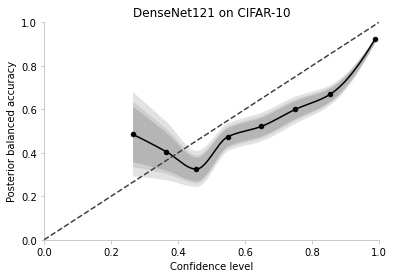

In [10]:
ax = plt.gca()
plt.title('DenseNet121 on CIFAR-10')
posterior_reliability_diagram(y_probs, y_preds, y_true, ax, bins=10)
plt.savefig('plots/densenet.pdf')
plt.show()